## Scanpy: clustering analysis
元URL: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

Scanpyを用いたクラスタリング解析です。流れはSeuratのTutorialとほぼ同じです。

以下の作業は Google Colab 上で行います。

In [67]:
# Scanpyインストール
!pip install seaborn scikit-learn statsmodels numba python-igraph louvain scanpy # pytables 

In [0]:
# ライブラリ読み込み
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3       # verbosity: errors (0), warnings (1), info (2), hints (3)
results_file = './pbmc3k.h5ad'  # the file that will store the analysis results

### データのダウンロード・読み込み

In [69]:
# データダウンロード・解凍
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
!tar zxvf pbmc3k_filtered_gene_bc_matrices.tar.gz

--2019-12-25 10:30:42--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 13.224.253.6, 13.224.253.76, 13.224.253.69, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|13.224.253.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘pbmc3k_filtered_gene_bc_matrices.tar.gz.2’

pbmc3k_filtered_gen 100%[===================>]   7.27M  28.3MB/s    in 0.3s    

2019-12-25 10:30:42 (28.3 MB/s) - ‘pbmc3k_filtered_gene_bc_matrices.tar.gz.2’ saved [7621991/7621991]

filtered_gene_bc_matrices/
filtered_gene_bc_matrices/hg19/
filtered_gene_bc_matrices/hg19/matrix.mtx
filtered_gene_bc_matrices/hg19/genes.tsv
filtered_gene_bc_matrices/hg19/barcodes.tsv


In [70]:
# データ読み込み
adata = sc.read_10x_mtx(
    'filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster s
sc.settings.set_figure_params(dpi=80)

... reading from cache file cache/filtered_gene_bc_matrices-hg19-matrix.h5ad


In [71]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'
adata

AnnData object with n_obs × n_vars = 2700 × 32738 
    var: 'gene_ids'

### 品質評価（QC）

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


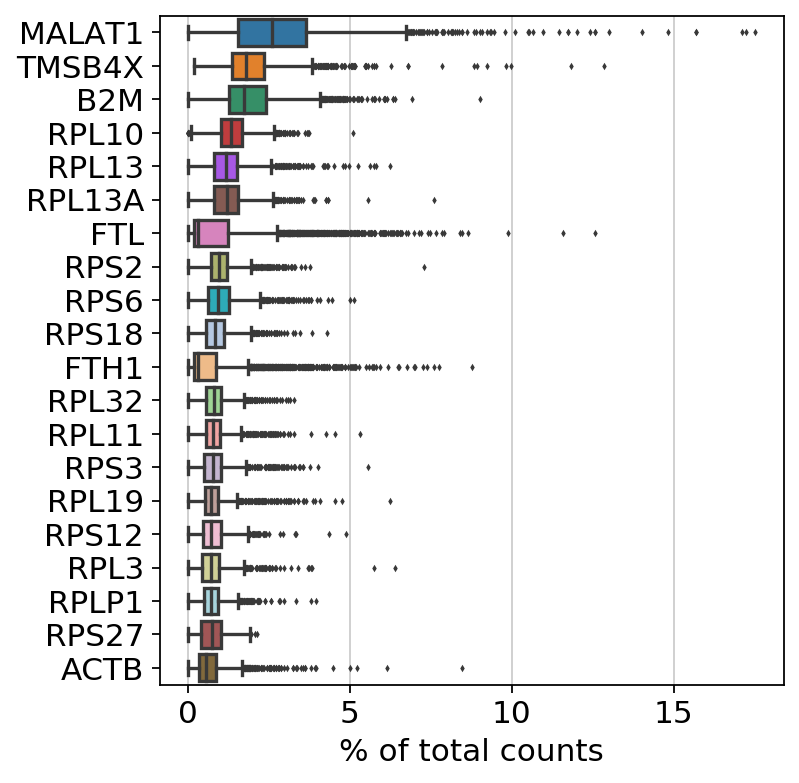

In [72]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [73]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detectedin less than 3 cells


In [0]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

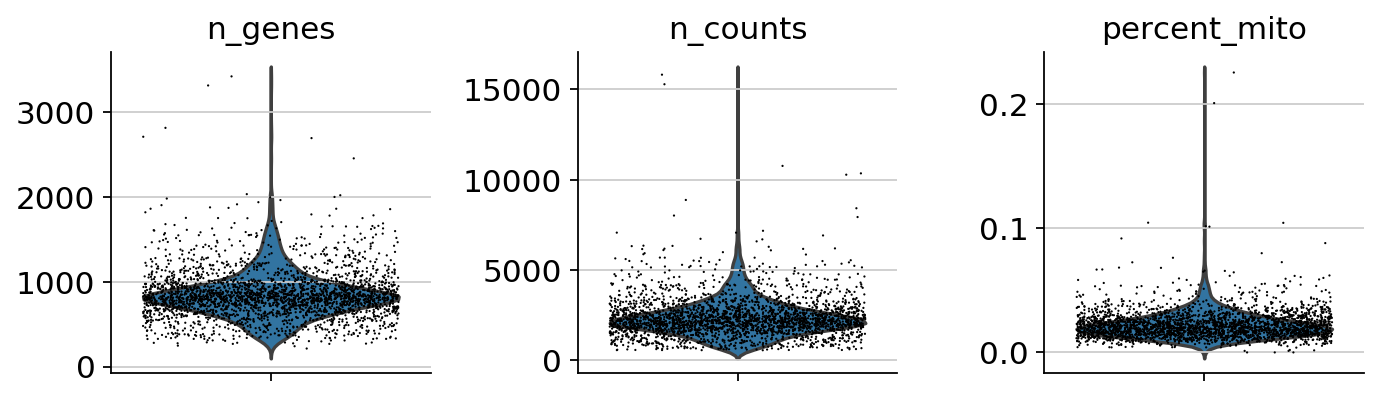

In [75]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)

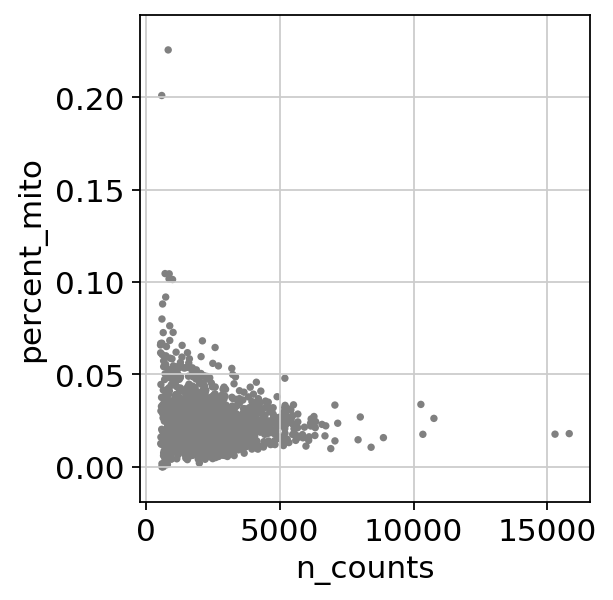

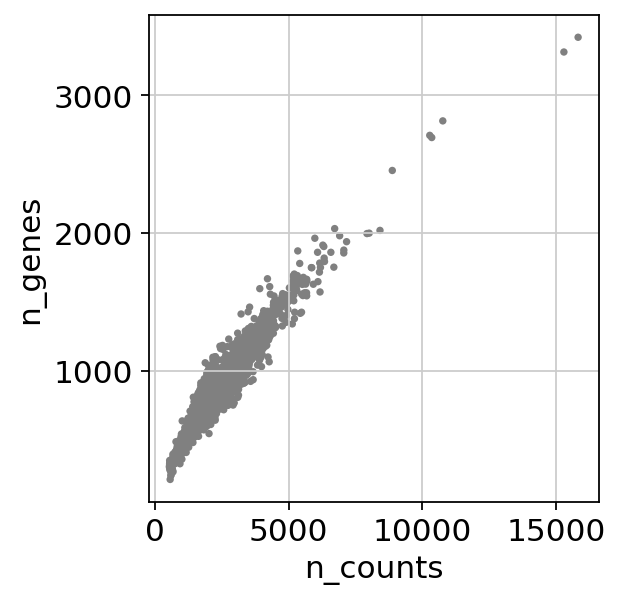

In [76]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [0]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [78]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [79]:
sc.pp.log1p(adata)

/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_simple.py:284: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if isinstance(data, AnnData) and data.isview:


In [0]:
adata.raw = adata

In [81]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


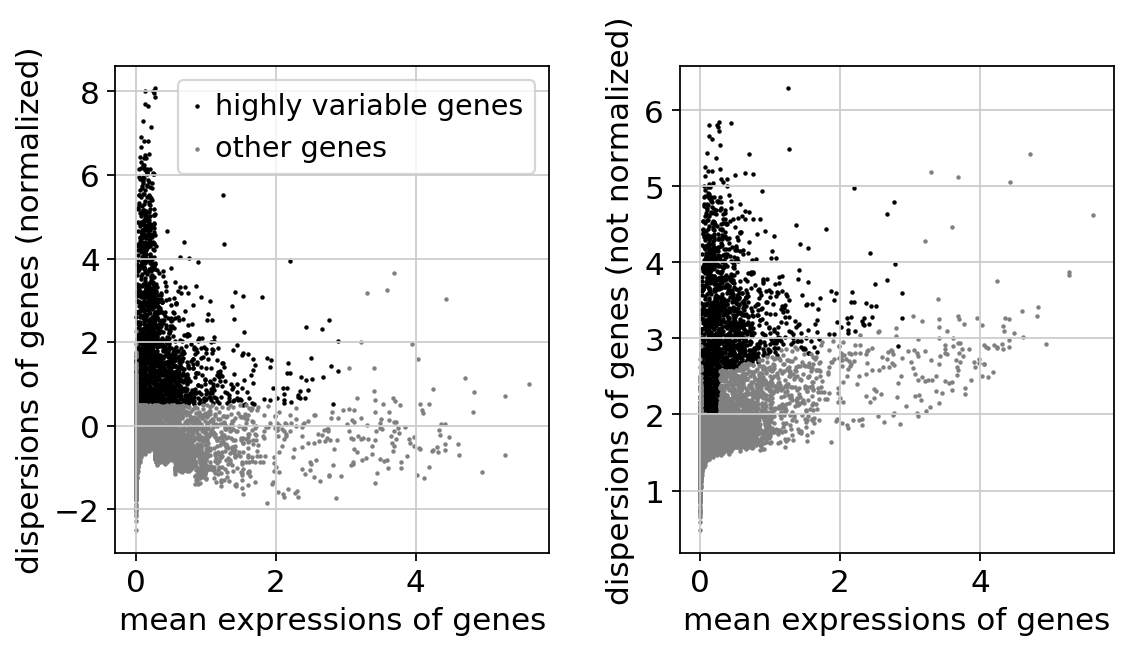

In [82]:
sc.pl.highly_variable_genes(adata)

In [0]:
adata = adata[:, adata.var['highly_variable']]

In [84]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1068: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning,


    finished (0:00:05)


In [85]:
sc.pp.scale(adata, max_value=10)

/usr/local/lib/python3.6/dist-packages/scanpy/utils.py:618: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:


### 次元削減

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01)


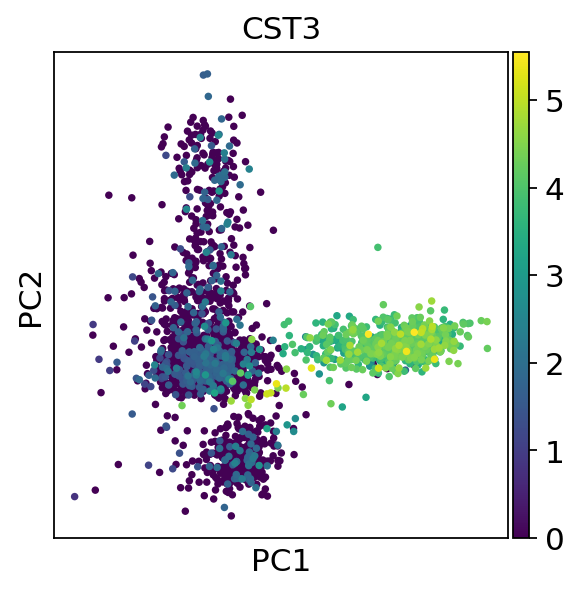

In [86]:
# Principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')

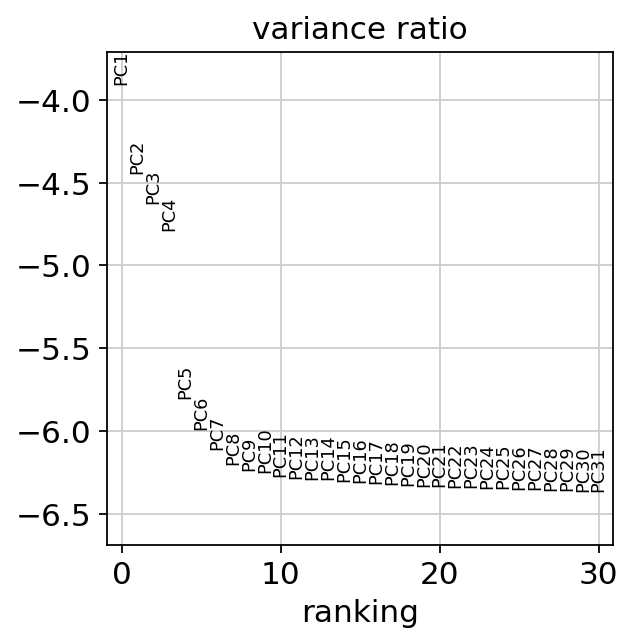

In [87]:
sc.pl.pca_variance_ratio(adata, log=True)

In [0]:
# Save the result
# 現在以下のエラーが出る為 writeは中止
# adata.write(results_file)

In [89]:
# adataに含まれる項目を表示
adata

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [90]:
# Computing the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40


/usr/local/lib/python3.6/dist-packages/scanpy/neighbors/__init__.py:89: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:  # we shouldn't need this here...


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


In [91]:
# UMAPの次元削減を実行
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


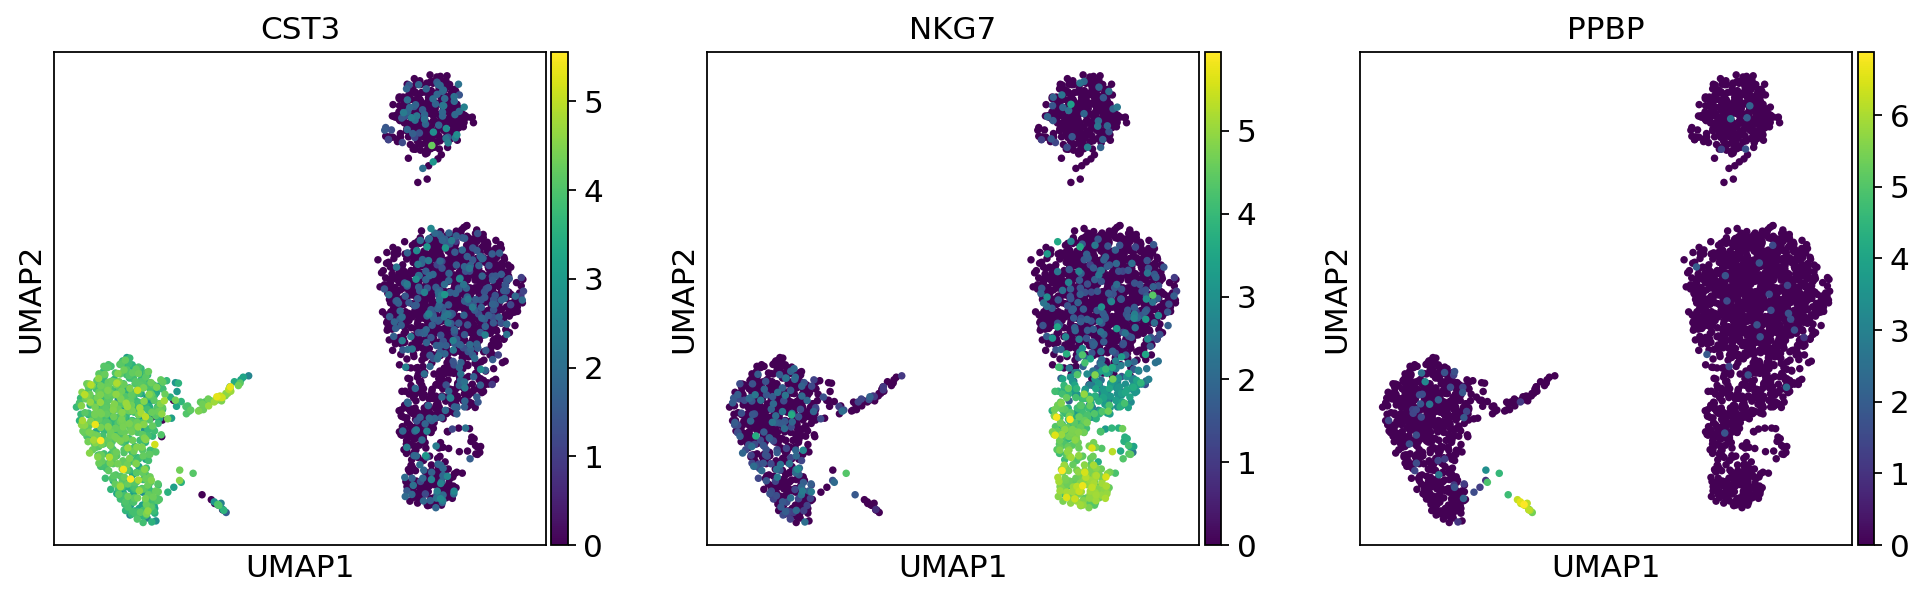

In [92]:
# 結果表示
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

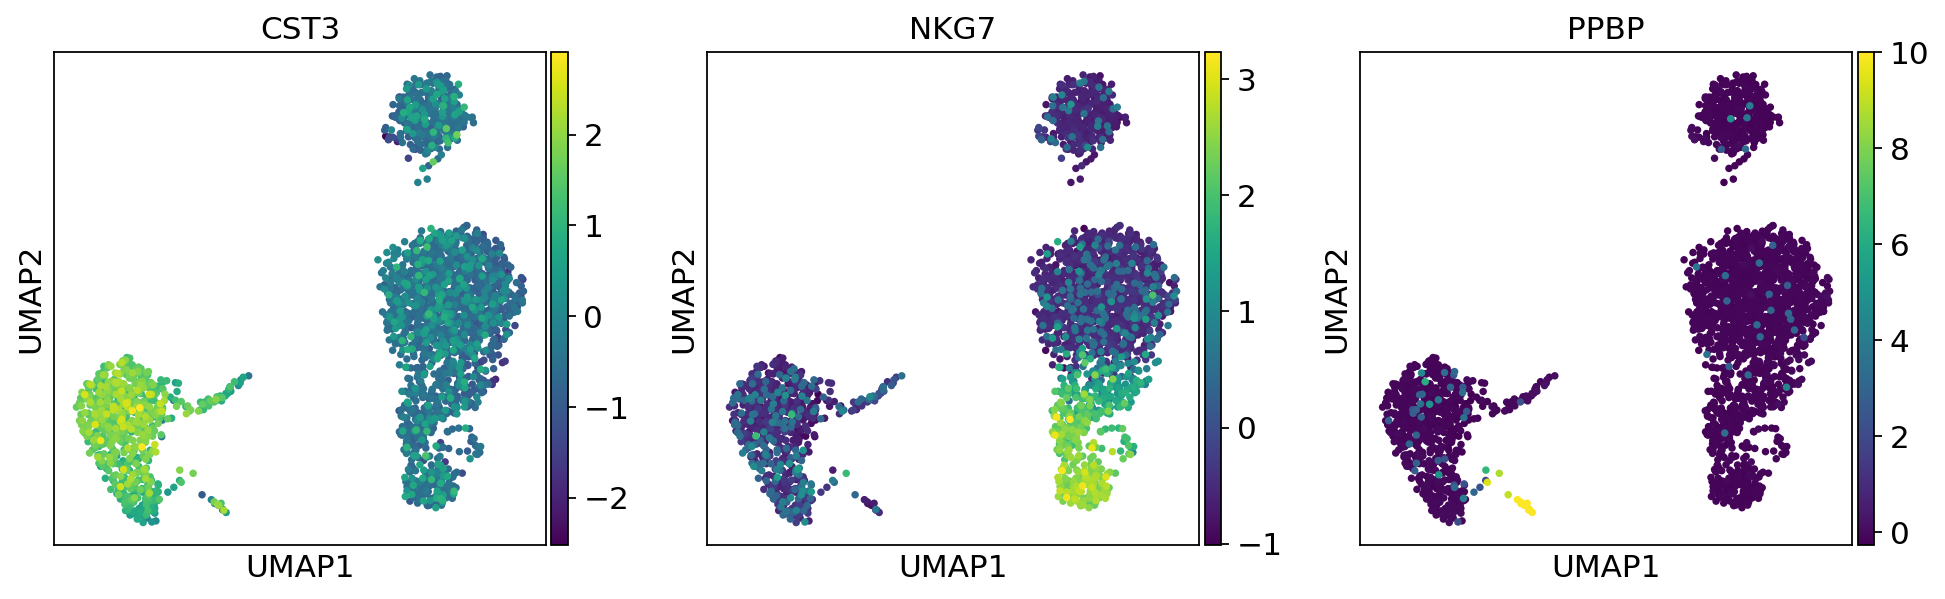

In [93]:
# use_raw=Falseを入れると、Total read normalizationと対数変換のみを行った発現量でプロットされます。
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

In [94]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


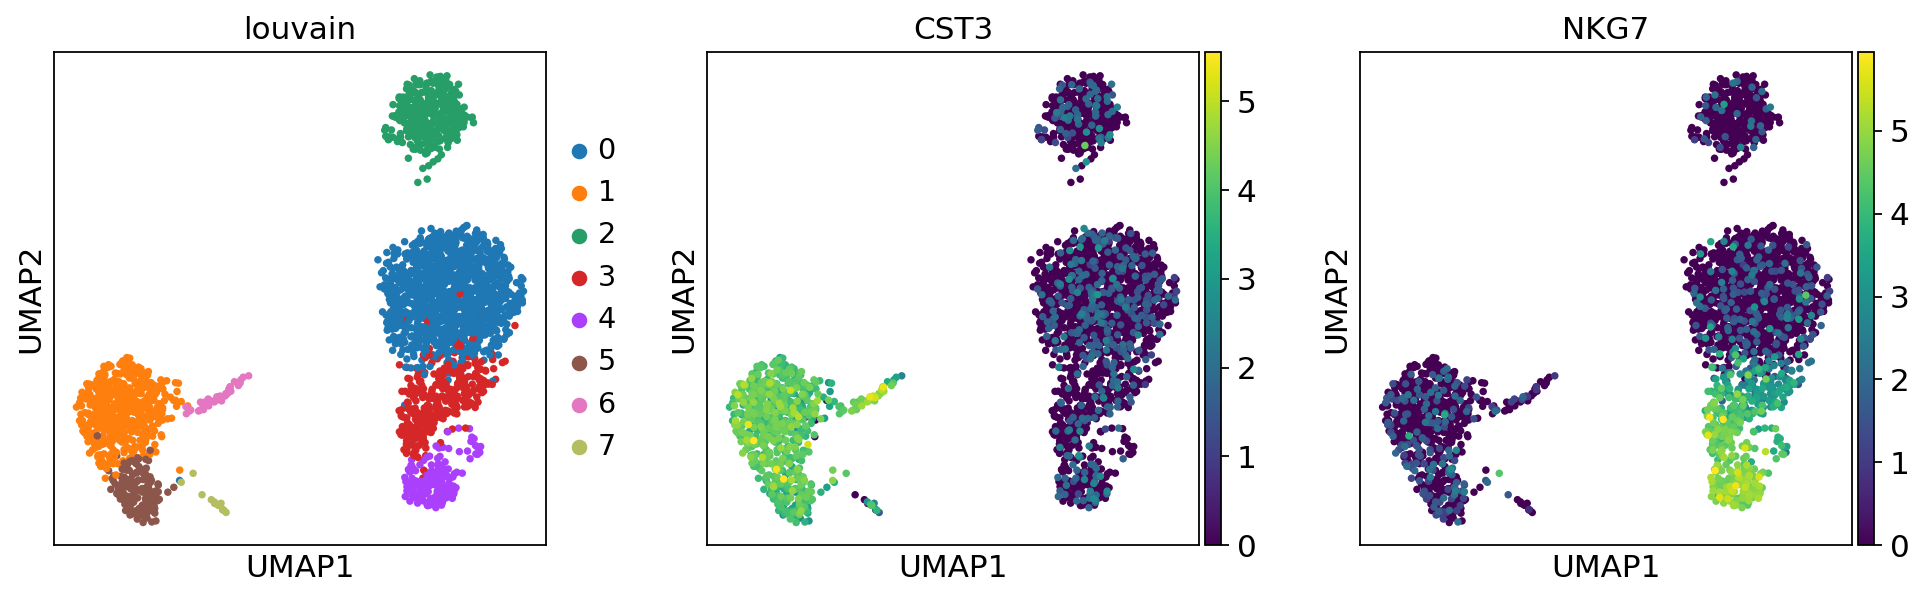

In [95]:
sc.pl.umap(adata, color=['louvain', 'CST3', 'NKG7'])

### マーカ遺伝子同定

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


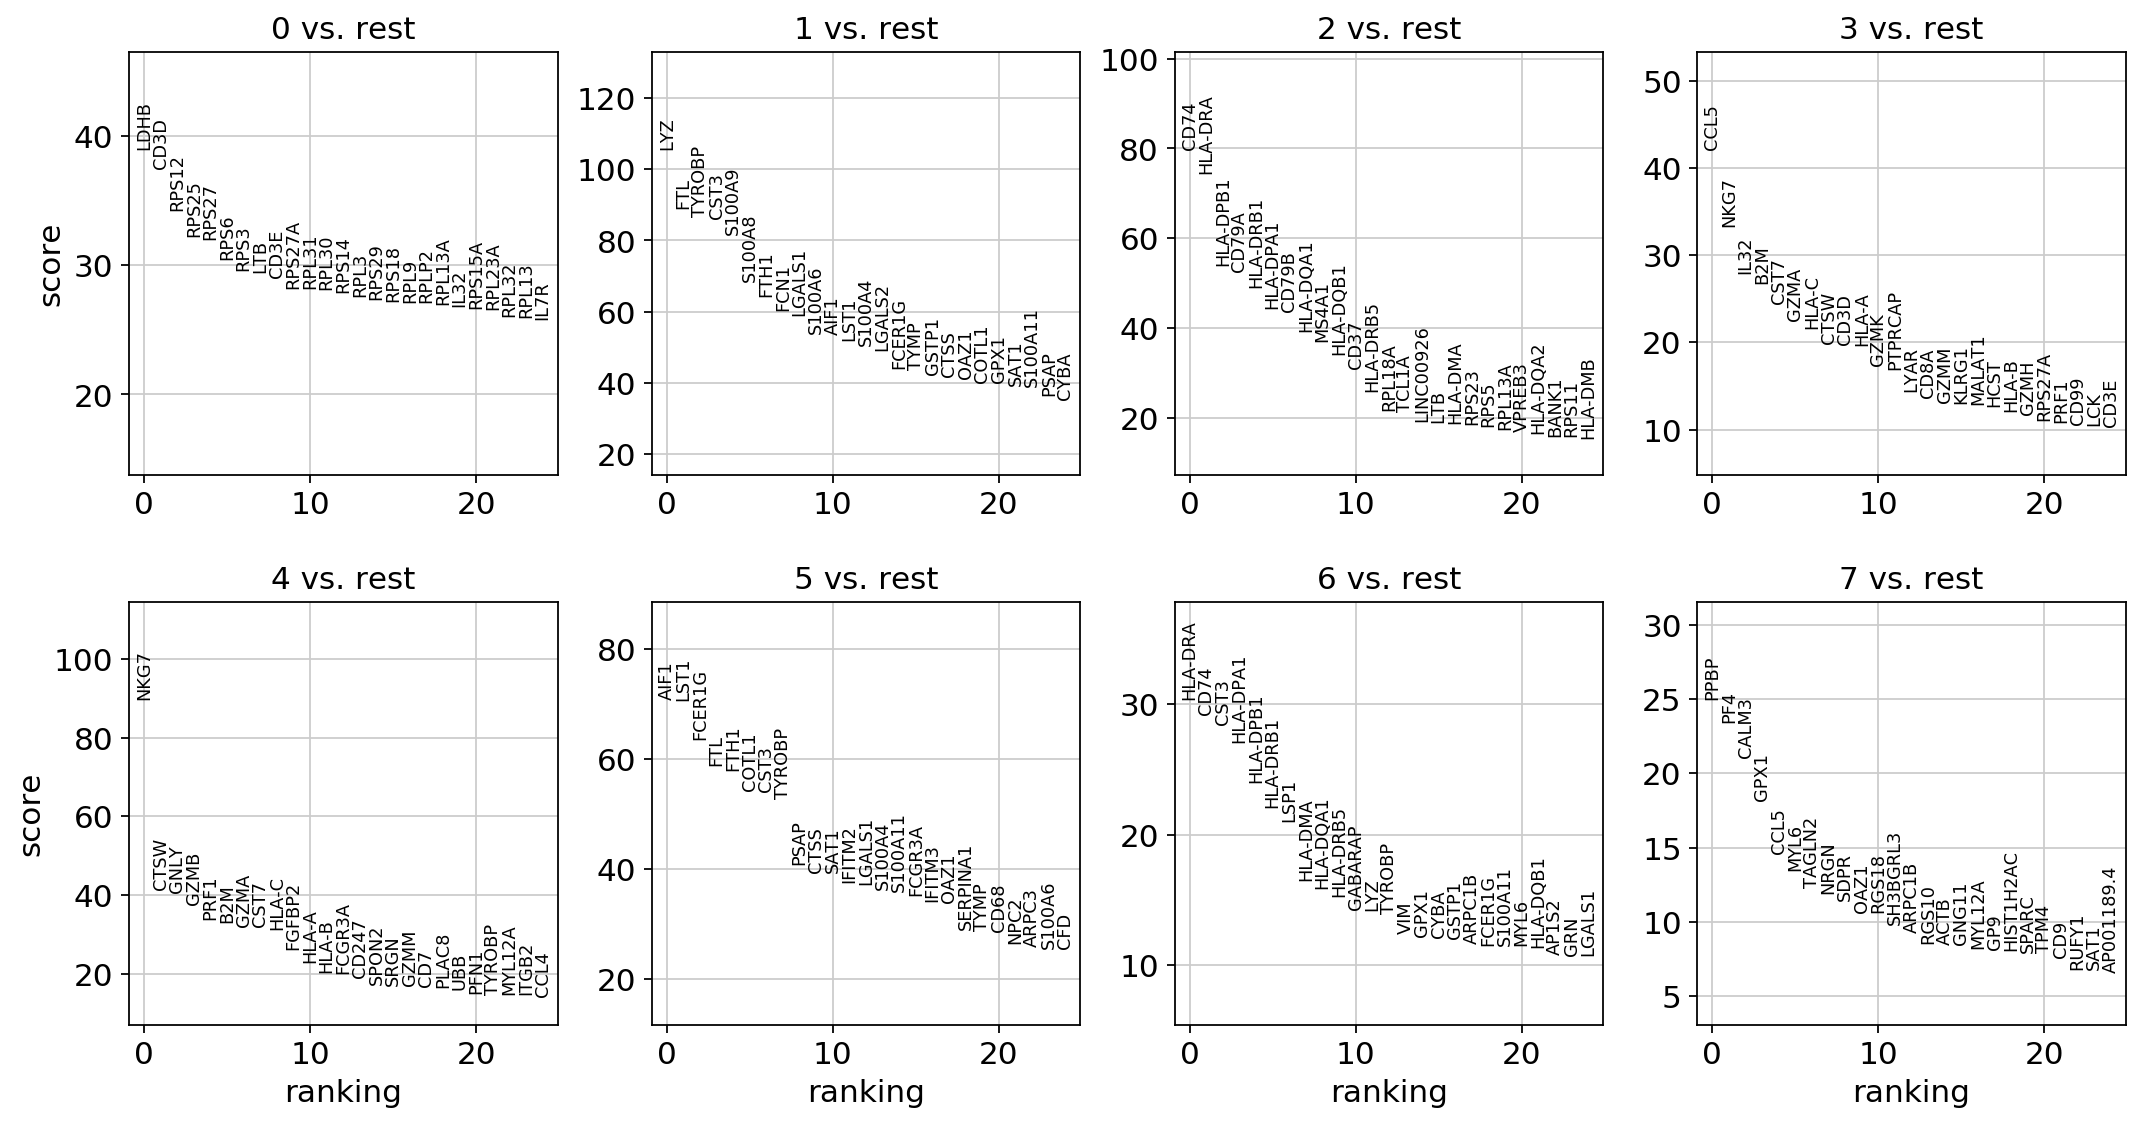

In [96]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


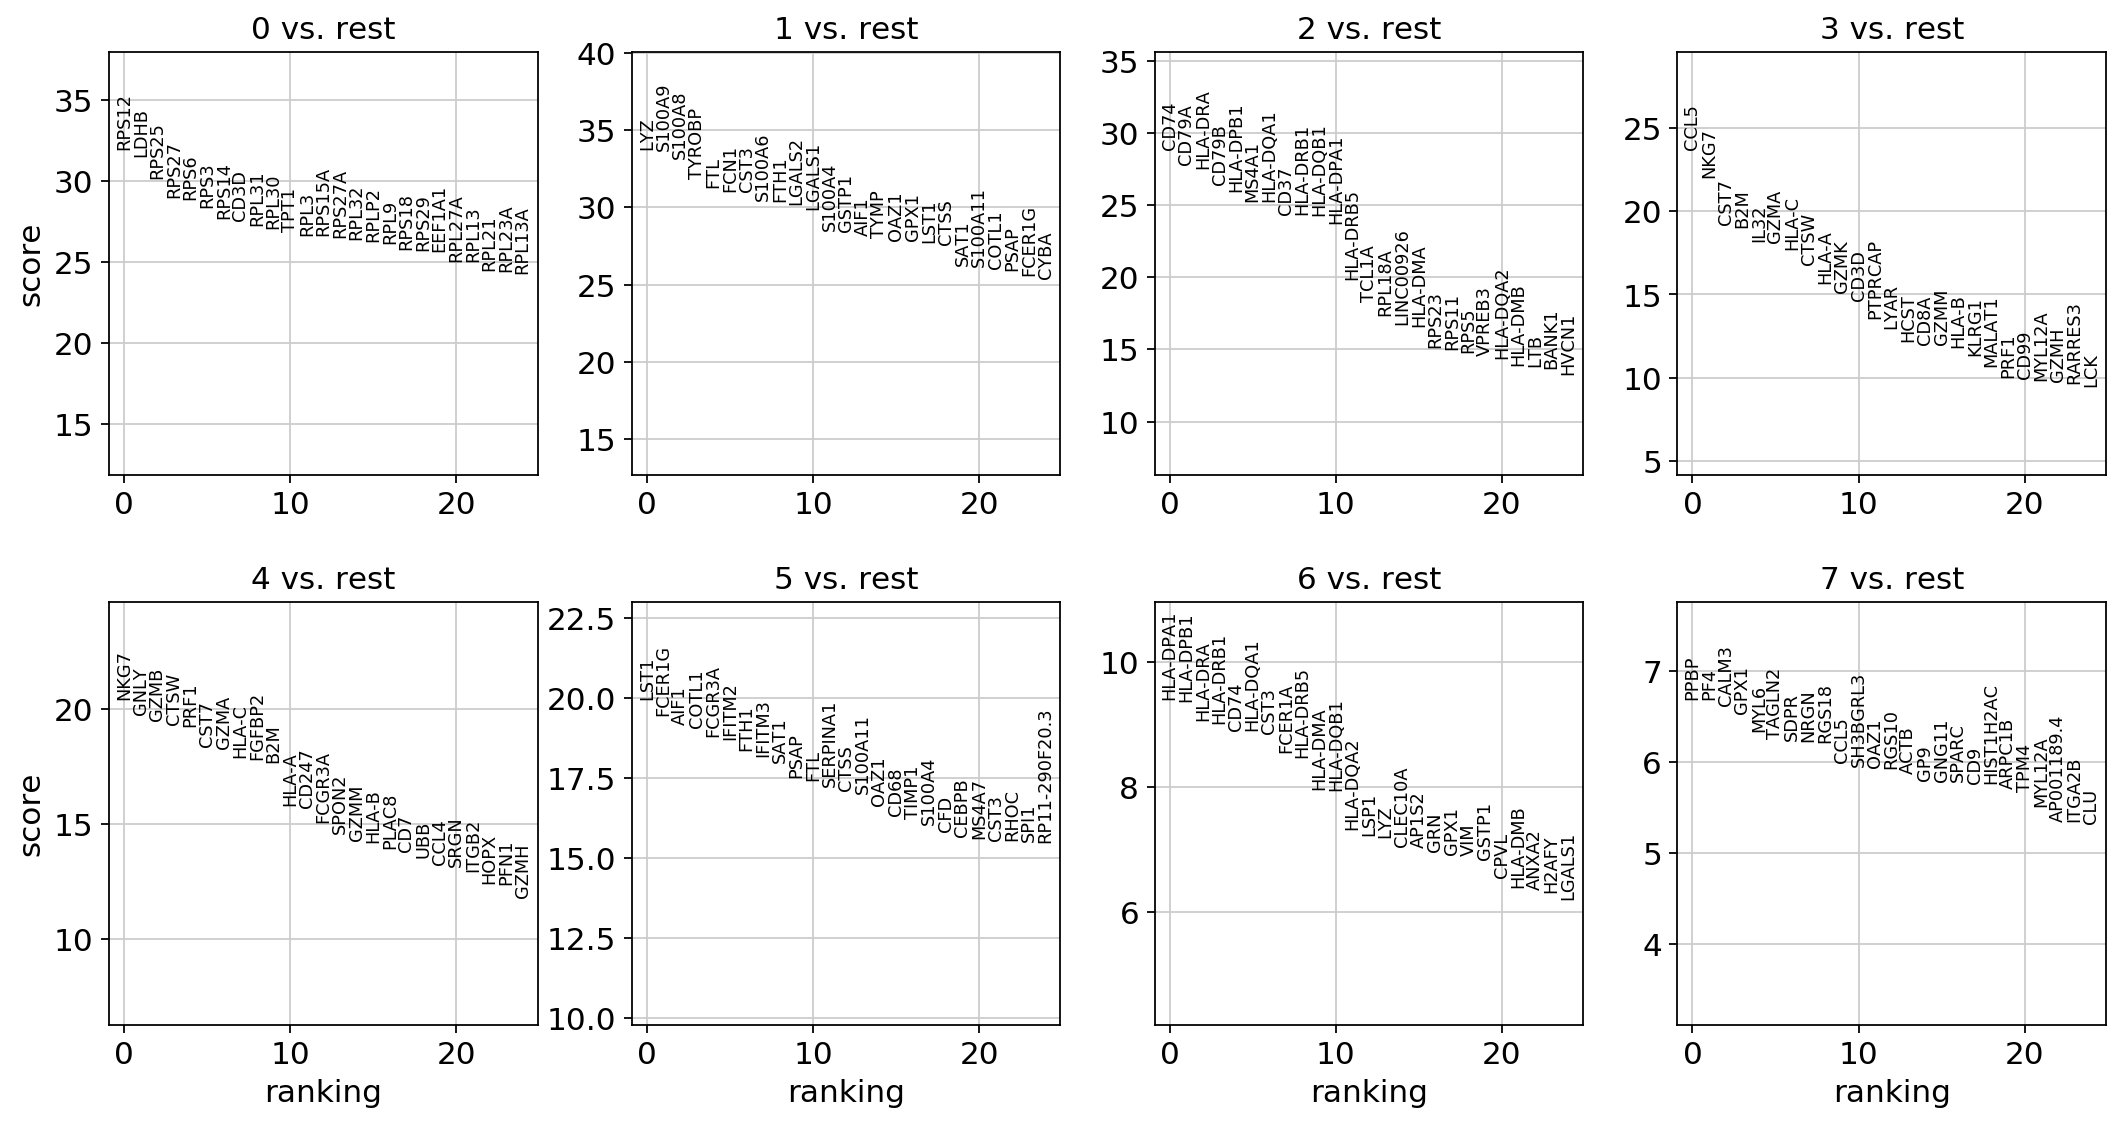

In [97]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1125: DeprecationWarning: During AnnData slicing, found matrix at .obs['neighbors']['distances'] that happens to be dimensioned at n_obs×n_obs (2638×2638). This slicing behavior will soon go away.
  DeprecationWarning,
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1125: DeprecationWarning: During AnnData slicing, found matrix at .obs['neighbors']['connectivities'] that happens to be dimensioned at n_obs×n_obs (2638×2638). This slicing behavior will soon go away.
  DeprecationWarning,
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", Futur

    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:03)


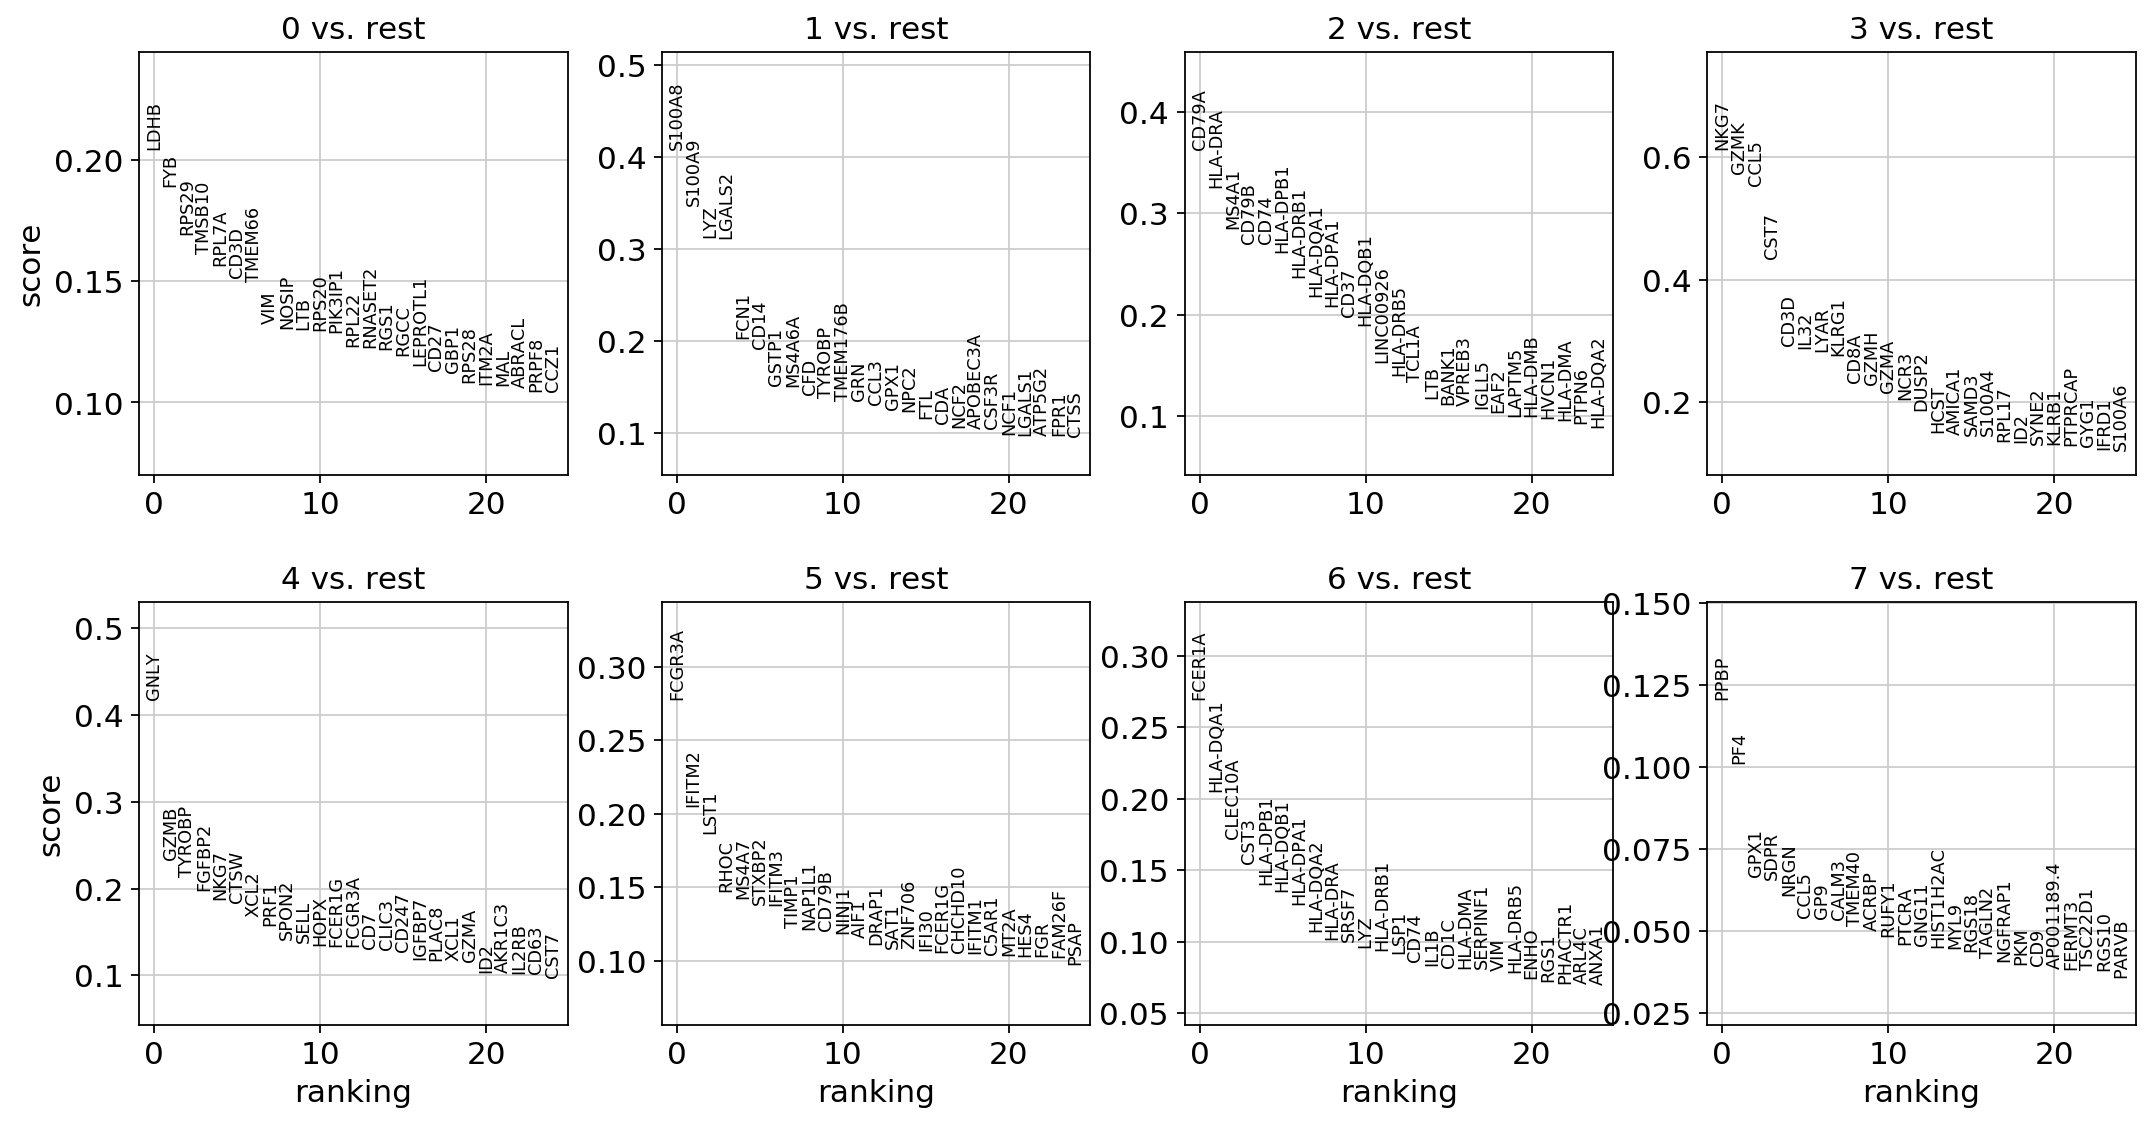

In [98]:
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [99]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7
0,LDHB,S100A8,CD79A,NKG7,GNLY,FCGR3A,FCER1A,PPBP
1,FYB,S100A9,HLA-DRA,GZMK,GZMB,IFITM2,HLA-DQA1,PF4
2,RPS29,LYZ,MS4A1,CCL5,TYROBP,LST1,CLEC10A,GPX1
3,TMSB10,LGALS2,CD79B,CST7,FGFBP2,RHOC,CST3,SDPR
4,RPL7A,FCN1,CD74,CD3D,NKG7,MS4A7,HLA-DPB1,NRGN


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


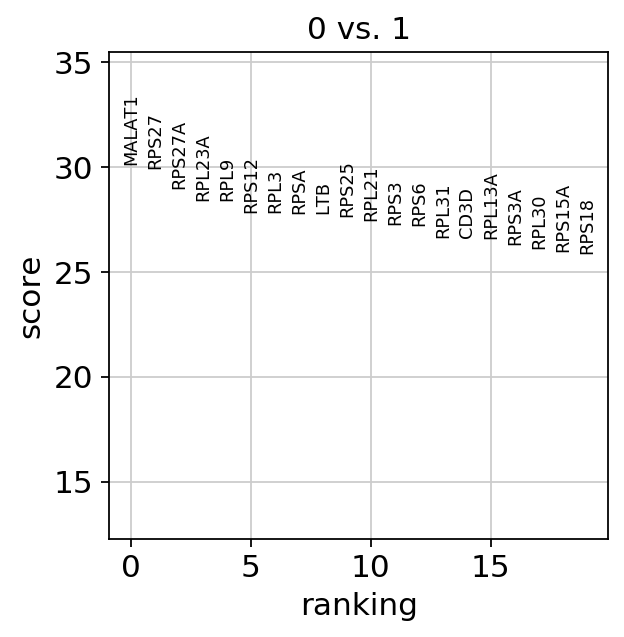

In [100]:
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

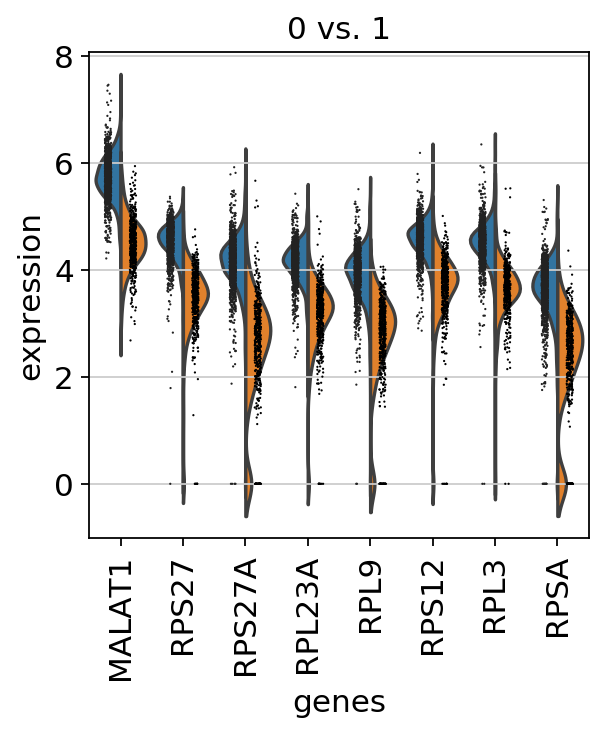

In [101]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:827: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  val = np.asscalar(support)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:828: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  d = np.asscalar(density)


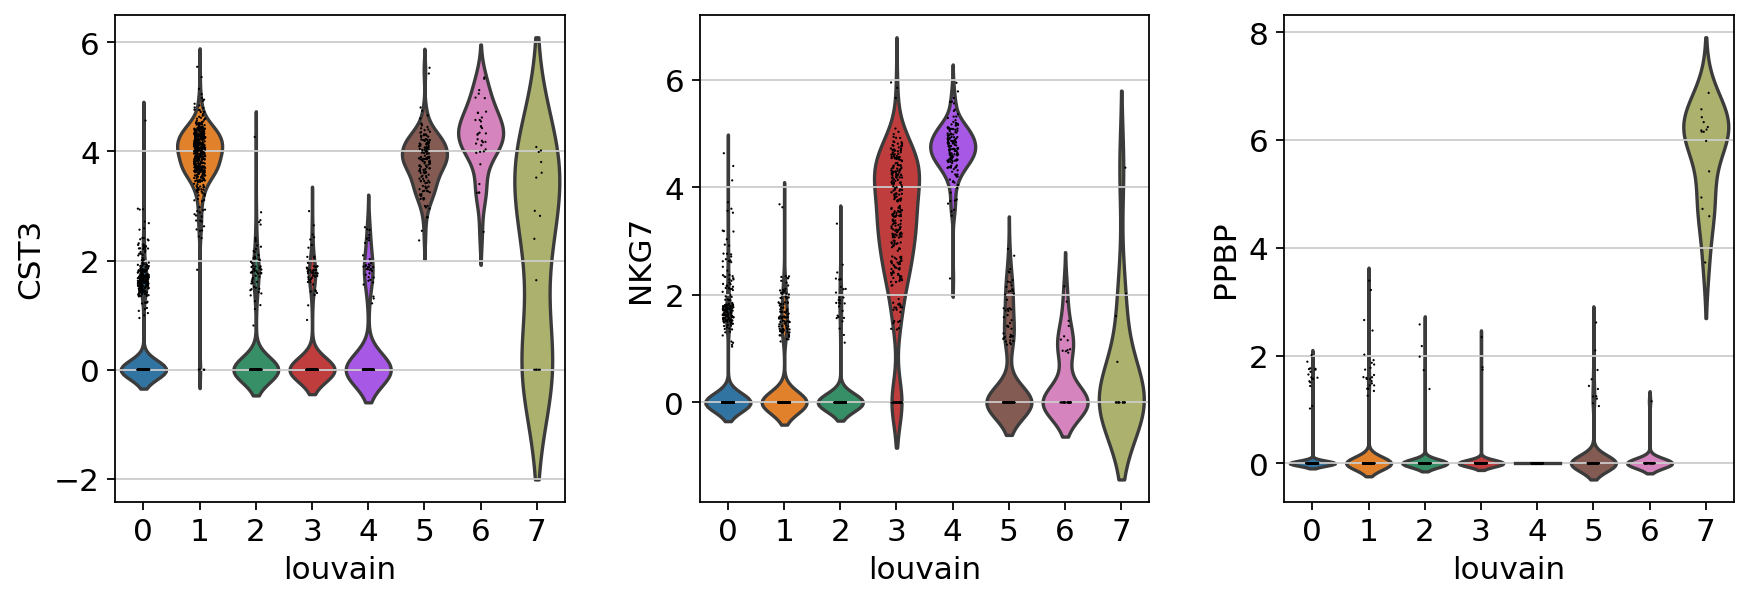

In [102]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='louvain')

### クラスタのアノテーション

In [103]:
new_cluster_names = [
    'CD4 T', 'CD14+ Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A+ Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('louvain', new_cluster_names)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Use self.obs[key].cat.categories = categories instead of rename_categories, rename_categories will be removed in the future.
  
Omitting rank_genes_groups/scores as old categories do not match.
Omitting rank_genes_groups/names as old categories do not match.
Omitting rank_genes_groups/logfoldchanges as old categories do not match.
Omitting rank_genes_groups/pvals as old categories do not match.
Omitting rank_genes_groups/pvals_adj as old categories do not match.


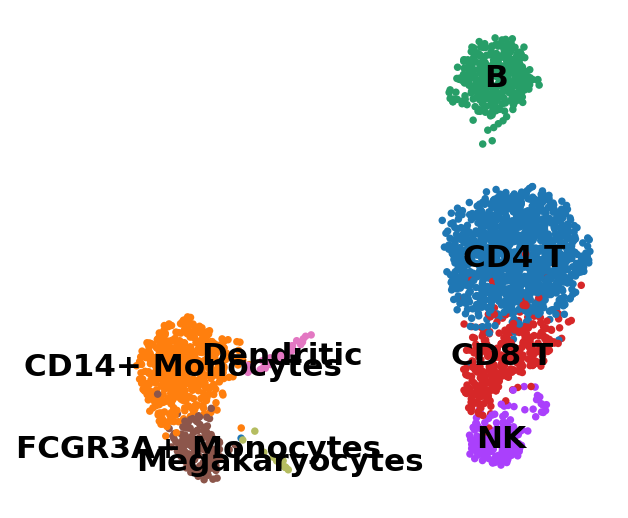

In [104]:
sc.pl.umap(adata, color='louvain', legend_loc='on data', title='', frameon=False, save='.pdf')

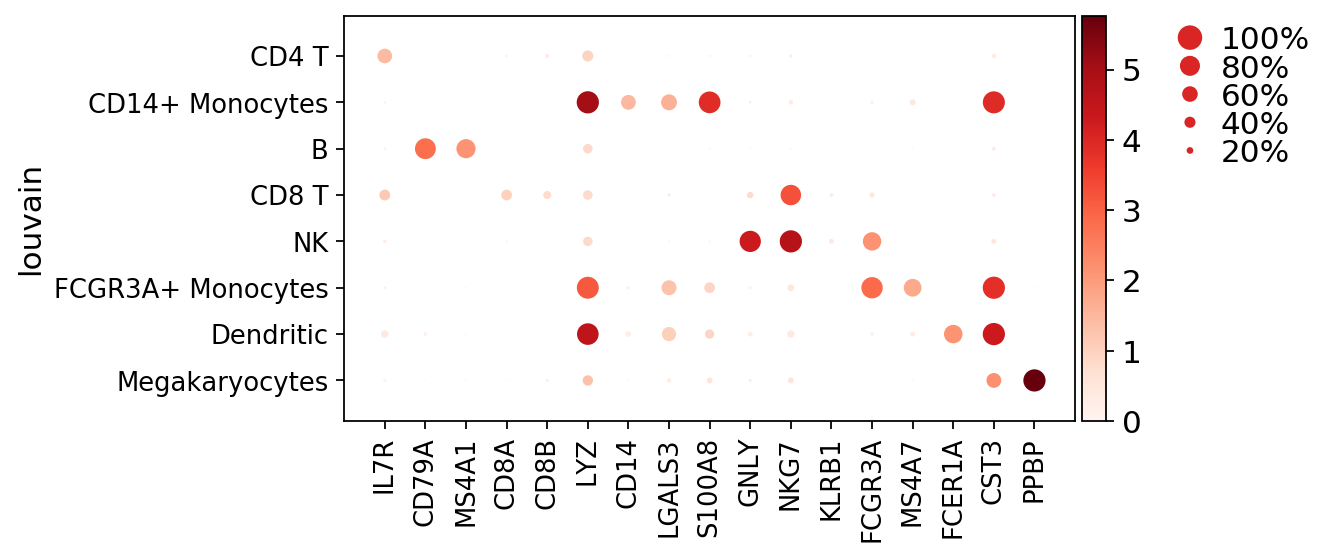

In [105]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']
ax = sc.pl.dotplot(adata, marker_genes, groupby='louvain')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:827: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  val = np.asscalar(support)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:828: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  d = np.asscalar(density)


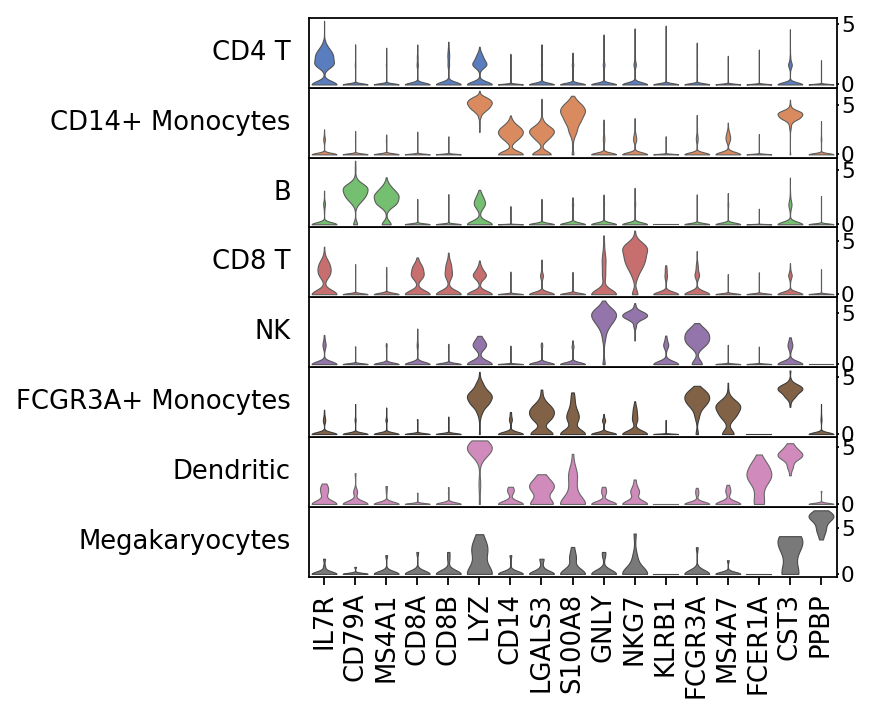

In [106]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain', rotation=90)

In [0]:
# adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading